# Homework: DGN with Temporal Relation Regularizer

## 20203230 박민제

In [2]:
import dgl
import numpy as np
import torch.nn as nn
import torch
import math
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output


from collections import namedtuple

Using backend: pytorch


## Environment

In [3]:
from simple_spread import Scenario

def make_env():
    from multiagent.environment import MultiAgentEnv

    scenario = Scenario()
    
    world = scenario.make_world()
    
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
    env.shared_reward = False
    
    return env

env = make_env()

In [17]:
def vis_state(env):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    
    # msking rectangle
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    
    # plotting agent and landmarks
    for entity in env.world.entities:
        color = entity.color
        size = entity.size
        center = entity.state.p_pos
        draw_circle = plt.Circle(center, size, color=color)
        ax.add_artist(draw_circle)
    plt.show()
    clear_output(wait=0.1)

## MLP

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dims=[32], hidden_act=nn.LeakyReLU(), out_act=nn.LeakyReLU()):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        
        in_dims = [in_dim] + hidden_dims
        out_dims = hidden_dims + [out_dim]
        
        for _in, _out in zip(in_dims, out_dims):
            self.layers.append(nn.Linear(_in, _out))
        
        for i in range(len(hidden_dims)):
            self.activations.append(hidden_act)
        self.activations.append(out_act)
        
    def forward(self, x):
        for l, a in zip(self.layers, self.activations):
            x = l(x)
            x = a(x)
            
        return x       

## Multi-head Attention Layer

In [5]:
class MultiHeadAttnLayer(nn.Module):
    def __init__(self, model_dim, num_heads=2, merge='cat'):
        super(MultiHeadAttnLayer, self).__init__()

        self.K = nn.ModuleList()
        self.Q = nn.ModuleList()
        self.V = nn.ModuleList()
        
        self.num_heads = num_heads
        self.merge = merge

        for i in range(num_heads):
            self.K.append(nn.Linear(model_dim, model_dim))
            self.Q.append(nn.Linear(model_dim, model_dim))
            self.V.append(nn.Linear(model_dim, model_dim))

        if merge == 'cat':
            self.O = nn.Linear(model_dim * num_heads, model_dim)
        else:
            # merge using 'mean'
            self.O = nn.Linear(model_dim, model_dim)


    def forward(self, graph, node_feature):
        graph.ndata['nf'] = node_feature
        graph.update_all(self.message_func, self.reduce_func, self.apply_nodes)

        out_nf = graph.ndata.pop('out_nf')
        _ = graph.ndata.pop('nf')
        weight = graph.ndata.pop('weight')

        return out_nf, weight

    def message_func(self, edges):
        # (i,j)
        src_nf = edges.src['nf'] # h_i, shape = [batch , model_dim]
        dst_nf = edges.dst['nf'] # h_j, shape = [batch , model_dim]

        ret_dict = dict()

        for h in range(self.num_heads):
            # computing score
            k = self.K[h](src_nf)  # shape = [batch , model_dim]
            q = self.Q[h](dst_nf)  # shape = [batch , model_dim]
            score = (k * q).sum(-1) # summation over model dimension
            score = score.reshape(-1, 1) # shape = [batch , 1]
            ret_dict['score_{}'.format(h)] = score
            
            # computing value
            ret_dict['value_{}'.format(h)] = self.V[h](src_nf) # shape = [batch, model_dim]

        return ret_dict

    def reduce_func(self, nodes):

        ret_dict = dict()

        for h in range(self.num_heads):
            value = nodes.mailbox['value_{}'.format(h)]  # shape = [batch , num_edges , model_dim]
            score = nodes.mailbox['score_{}'.format(h)]  # shape = [batch , num_edges , 1]
            
            weight = torch.softmax(score, dim=1)  # shape = [batch , num_edges , 1]

            weighted_value_sum = (weight * value).sum(1)  # summation over edge dimension
            ret_dict['wv_{}'.format(h)] = weighted_value_sum
            
            ret_dict['w_{}'.format(h)] = weight.squeeze()

        return ret_dict

    def apply_nodes(self, nodes):
        o_input = []
        weights = []
        for h in range(self.num_heads):
            o_input.append(nodes.data['wv_{}'.format(h)])  # shape = [# nodes , model_dim]
            weights.append(nodes.data['w_{}'.format(h)])

        if self.merge == 'cat':
            o_input = torch.cat(o_input, dim=-1)
        else:
            o_input = torch.stack(o_input)  # shape = [# heads , # nodes , model_dim]
            o_input = o_input.mean(0)  # mean over attn head dimension
            
        weights = torch.stack(weights)
        weights = weights.mean(0)

        o = self.O(o_input)
        return {'out_nf': o, 'weight':weights}

## GNN

In [20]:
class RelationalGNN(nn.Module):
    def __init__(self, init_dim, hidden_dim, num_layers=1, num_heads=2, merge='cat'):
        super(RelationalGNN, self).__init__()
        
        self.encoder = MLP(init_dim, hidden_dim) # first encode the node feature to hidden_dim
        self.attn = nn.ModuleList()
        
        for i in range(num_layers):
            self.attn.append(MultiHeadAttnLayer(hidden_dim, num_heads, merge))
            
    def forward(self, graph, node_feature):
        node_feature = self.encoder(node_feature)
        
        for attn_layer in self.attn:
            node_feature, weight = attn_layer(graph, node_feature)
            
        return node_feature, weight       

## Agent

In [39]:
Transition = namedtuple('Transition', ('graph', 'action', 'reward', 'next_graph', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Save Transitions"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        samples = random.sample(self.memory, batch_size)
        
        graphs = [sample[0] for sample in samples]
        actions = [sample[1] for sample in samples]
        rewards = [sample[2] for sample in samples]
        next_graphs = [sample[3] for sample in samples]
        dones = [sample[4] for sample in samples]
        
        ret_graph = dgl.batch(graphs, node_attrs=['obs'])
        ret_action = torch.stack(actions).reshape(-1, 1)
        ret_reward = torch.Tensor(rewards).reshape(-1)
        ret_next_graph = dgl.batch(next_graphs, node_attrs=['obs'])
        ret_dones = torch.Tensor(dones).reshape(-1)
        
        return ret_graph, ret_action, ret_reward, ret_next_graph, ret_dones

    def __len__(self):
        return len(self.memory)

## Converting observation to graph

In [24]:
def get_fully_connected_edges(num_agents, self_edge=True):
    from_idx = []
    to_idx = []
    for i in range(num_agents):
        for j in range(num_agents):
            if self_edge:
                from_idx.append(i)
                to_idx.append(j)
            else:
                if i!=j:
                    from_idx.append(i)
                    to_idx.append(j)
    return from_idx, to_idx

def generate_graph_with_obs(obs):
    g = dgl.DGLGraph()
    n_agents = len(obs)
    g.add_nodes(n_agents)
    
    from_idx, to_idx = get_fully_connected_edges(n_agents, self_edge=True)
    g.add_edges(from_idx, to_idx)
    
    # we save observation as the feature of the nodes
    g.ndata['obs'] = torch.Tensor(obs) # shape = (n_agents x state_dim)

    return g

# Implementation: Temporal Relation Regularization

\begin{equation}
\mathcal{L}(\theta)=\frac{1}{\mathrm{S}}\sum_{\mathrm{S}}\frac{1}{\mathrm{N}}\sum_{i=1}^{\mathrm{N}}\left( y_{i}-Q(O_{i,\mathcal{C}},a_{i};\theta) \right)^{2}
+\underline{\lambda\frac{1}{\mathrm{M}}\sum_{m=1}^{\mathrm{M}}\mathrm{KL}\left( \mathcal{G}_{m}^{\kappa}(O_{i,\mathcal{C}};\theta)|| \mathcal{G}_{m}^{\kappa}(O_{i,\mathcal{C}}';\theta) \right)}
\end{equation}

In [40]:
class Agent(nn.Module):
    def __init__(self, n_agents, state_dim, n_actions, hidden_dim=20, gamma=0.9, memory_size=5000, batch_size=20,
                epsilon_start = 0.99, epsilon_decay = 0.9999, epsilon_min= 0.01, update_target=50, lamb=None):
        super(Agent, self).__init__()
        self.GNN = RelationalGNN(state_dim, hidden_dim) 
        self.Qnet = MLP(hidden_dim, n_actions, out_act=nn.Identity()) # Q-network
        self.target_Qnet = MLP(hidden_dim, n_actions, out_act=nn.Identity()) #target Q-network

        # Initialize target Qnet
        self.target_Qnet.load_state_dict(self.Qnet.state_dict())
        
        # the Q network and GNN are trained with end-to-end framework
        self.optimizer = torch.optim.Adam(list(self.GNN.parameters()) + list(self.Qnet.parameters()), lr=1e-4)
        self.loss_ftn = nn.MSELoss()

        self.gamma = gamma
        
        # epsilon for exploration
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.memory = ReplayMemory(memory_size)
        self.batch_size = batch_size

        self.num_fit = 0
        self.update_target = update_target # update target network every {X} fits

        self.n_agents = n_agents
        self.n_actions = n_actions
        
        # multiplier for the KL term
        self.lamb = lamb

    def get_action(self, graph):
        rand_num = random.random()

        # exploration
        if rand_num < self.epsilon:
            action = torch.randint(low=0, high=self.n_actions, size=(self.n_agents,))

        else:
            # exploitation
            qs, _ = self.get_qs(graph)
            action = qs.argmax(dim=-1).detach()

        # decaying epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        # convert integer action to environment action
        env_action = self.convert_to_onehot_action(action)

        return action, env_action

    def get_qs(self, graph):
        observation = graph.ndata['obs']
        node_feature, weight = self.GNN(graph, observation)
        qs = self.Qnet(node_feature)

        # return q-value with relation weight of last layer
        return qs, weight

    def get_target_qs(self, graph):
        observation = graph.ndata['obs']
        node_feature, weight = self.GNN(graph, observation)
        qs = self.target_Qnet(node_feature)

        # return q-value with relation weight of last layer
        return qs, weight

    def save_samples(self, g, a, r, n_g, t):
        self.memory.push(g, a, r, n_g, t)

    def fit(self):
        
        if len(self.memory) < self.batch_size * 10:
            return False, 0

        graph, action, reward, next_graph, done = self.memory.sample(self.batch_size)

        curr_qs, curr_weight = self.get_qs(graph)
        selected_qs = curr_qs.gather(1, action).reshape(-1)

        next_qs, next_weight = self.get_target_qs(next_graph)
        next_max_qs, _ = next_qs.max(dim=1)
        target = reward + self.gamma * next_max_qs * (1 - done)
        target = target.detach()
        
        # KL term
        KL = (curr_weight * torch.log(curr_weight/next_weight)).sum(-1)

        # Regularized loss
        if self.lamb is None:
            loss = self.loss_ftn(selected_qs, target)
        else:
            loss = self.loss_ftn(selected_qs, target) + self.lamb*KL.mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.num_fit % self.update_target == 0:
            self.target_Qnet.load_state_dict(self.Qnet.state_dict())

        self.num_fit += 1

        return True, loss.item()

    def convert_to_onehot_action(self, actions):
        onehot_action = [[0 for _ in range(self.n_actions)] for _ in range(self.n_agents)]
        for i in range(self.n_agents):
            selected_action = actions[i] 
            onehot_action[i][selected_action] = 1
        return onehot_action

# Experiment 1: Without regularization

EP:0, SUM_RWD:-5.99, epsilon: 0.99, loss: 0.00
EP:1, SUM_RWD:-17.88, epsilon: 0.99, loss: 0.00
EP:2, SUM_RWD:-54.69, epsilon: 0.99, loss: 0.00
EP:3, SUM_RWD:-68.57, epsilon: 0.98, loss: 0.00
EP:4, SUM_RWD:-31.91, epsilon: 0.98, loss: 0.00
EP:5, SUM_RWD:-37.07, epsilon: 0.98, loss: 0.00
EP:6, SUM_RWD:-26.64, epsilon: 0.98, loss: 0.00
EP:7, SUM_RWD:-29.00, epsilon: 0.98, loss: 0.00
EP:8, SUM_RWD:-9.17, epsilon: 0.98, loss: 0.00
EP:9, SUM_RWD:-17.90, epsilon: 0.98, loss: 0.00
EP:10, SUM_RWD:-17.17, epsilon: 0.97, loss: 0.00
EP:11, SUM_RWD:-42.75, epsilon: 0.97, loss: 0.00
EP:12, SUM_RWD:-10.60, epsilon: 0.97, loss: 0.00
EP:13, SUM_RWD:-6.98, epsilon: 0.97, loss: 0.63
EP:14, SUM_RWD:-32.36, epsilon: 0.97, loss: 0.66
EP:15, SUM_RWD:-15.99, epsilon: 0.97, loss: 0.48
EP:16, SUM_RWD:-31.54, epsilon: 0.97, loss: 0.75
EP:17, SUM_RWD:-30.28, epsilon: 0.96, loss: 0.59
EP:18, SUM_RWD:-51.23, epsilon: 0.96, loss: 0.74
EP:19, SUM_RWD:-32.92, epsilon: 0.96, loss: 0.60
EP:20, SUM_RWD:-31.69, epsilon: 0

EP:166, SUM_RWD:-25.68, epsilon: 0.77, loss:10124.67
EP:167, SUM_RWD:-27.32, epsilon: 0.77, loss:3241.00
EP:168, SUM_RWD:-13.42, epsilon: 0.77, loss:7657.61
EP:169, SUM_RWD:-18.97, epsilon: 0.77, loss:12546.53
EP:170, SUM_RWD:-31.81, epsilon: 0.77, loss:12331.77
EP:171, SUM_RWD:-37.92, epsilon: 0.76, loss:3456.92
EP:172, SUM_RWD:-43.15, epsilon: 0.76, loss:10881.43
EP:173, SUM_RWD:-27.58, epsilon: 0.76, loss:9018.95
EP:174, SUM_RWD:-18.95, epsilon: 0.76, loss:17170.86
EP:175, SUM_RWD:-35.05, epsilon: 0.76, loss:6804.17
EP:176, SUM_RWD:-38.28, epsilon: 0.76, loss:6550.09
EP:177, SUM_RWD:-15.99, epsilon: 0.76, loss:4281.21
EP:178, SUM_RWD:-23.63, epsilon: 0.76, loss:17025.54
EP:179, SUM_RWD:-26.62, epsilon: 0.76, loss:9841.04
EP:180, SUM_RWD:-22.08, epsilon: 0.75, loss:8887.90
EP:181, SUM_RWD:-21.86, epsilon: 0.75, loss:12817.45
EP:182, SUM_RWD:-23.98, epsilon: 0.75, loss:12227.28
EP:183, SUM_RWD:-18.02, epsilon: 0.75, loss:4588.12
EP:184, SUM_RWD:-27.83, epsilon: 0.75, loss:9045.41
EP:1

EP:323, SUM_RWD:-37.11, epsilon: 0.61, loss:1633.53
EP:324, SUM_RWD:-26.19, epsilon: 0.61, loss:2024.37
EP:325, SUM_RWD:-19.64, epsilon: 0.61, loss:1471.57
EP:326, SUM_RWD:-11.66, epsilon: 0.61, loss:2090.37
EP:327, SUM_RWD:-21.37, epsilon: 0.61, loss:1666.02
EP:328, SUM_RWD:-31.32, epsilon: 0.60, loss:1320.80
EP:329, SUM_RWD:-39.30, epsilon: 0.60, loss:1166.93
EP:330, SUM_RWD:-32.64, epsilon: 0.60, loss:1127.08
EP:331, SUM_RWD:-29.85, epsilon: 0.60, loss:753.91
EP:332, SUM_RWD:-4.48, epsilon: 0.60, loss:1232.56
EP:333, SUM_RWD:-13.83, epsilon: 0.60, loss:2276.22
EP:334, SUM_RWD:-19.65, epsilon: 0.60, loss:1149.40
EP:335, SUM_RWD:-2.90, epsilon: 0.60, loss:796.76
EP:336, SUM_RWD:-31.87, epsilon: 0.60, loss:576.85
EP:337, SUM_RWD:-31.61, epsilon: 0.60, loss:800.47
EP:338, SUM_RWD:-34.77, epsilon: 0.60, loss:879.70
EP:339, SUM_RWD:-30.44, epsilon: 0.59, loss:710.75
EP:340, SUM_RWD:-16.00, epsilon: 0.59, loss:885.87
EP:341, SUM_RWD:-24.47, epsilon: 0.59, loss:812.96
EP:342, SUM_RWD:-35.78

EP:485, SUM_RWD:-38.27, epsilon: 0.48, loss:138.11
EP:486, SUM_RWD:-26.49, epsilon: 0.48, loss:182.59
EP:487, SUM_RWD:-15.54, epsilon: 0.48, loss:66.22
EP:488, SUM_RWD:-17.65, epsilon: 0.48, loss:22.80
EP:489, SUM_RWD:-23.73, epsilon: 0.47, loss:152.53
EP:490, SUM_RWD:-19.74, epsilon: 0.47, loss:112.43
EP:491, SUM_RWD:-51.61, epsilon: 0.47, loss:173.70
EP:492, SUM_RWD:-34.72, epsilon: 0.47, loss:81.20
EP:493, SUM_RWD:-2.46, epsilon: 0.47, loss:95.79
EP:494, SUM_RWD:-27.64, epsilon: 0.47, loss:89.72
EP:495, SUM_RWD:-20.46, epsilon: 0.47, loss:105.64
EP:496, SUM_RWD:-13.30, epsilon: 0.47, loss:230.12
EP:497, SUM_RWD:-19.58, epsilon: 0.47, loss:188.00
EP:498, SUM_RWD:-50.44, epsilon: 0.47, loss:147.06
EP:499, SUM_RWD:-32.50, epsilon: 0.47, loss:143.57
EP:500, SUM_RWD:-30.45, epsilon: 0.47, loss:302.27
EP:501, SUM_RWD:-19.18, epsilon: 0.47, loss:66.24
EP:502, SUM_RWD:-29.91, epsilon: 0.47, loss:150.95
EP:503, SUM_RWD:-20.65, epsilon: 0.46, loss:58.52
EP:504, SUM_RWD:16.45, epsilon: 0.46, l

EP:650, SUM_RWD:-14.49, epsilon: 0.37, loss:17.53
EP:651, SUM_RWD:-40.72, epsilon: 0.37, loss:17.90
EP:652, SUM_RWD:-38.29, epsilon: 0.37, loss:16.08
EP:653, SUM_RWD:-14.21, epsilon: 0.37, loss:11.93
EP:654, SUM_RWD:-25.86, epsilon: 0.37, loss:16.02
EP:655, SUM_RWD:-47.52, epsilon: 0.37, loss:16.19
EP:656, SUM_RWD:-21.14, epsilon: 0.37, loss:11.58
EP:657, SUM_RWD:-19.76, epsilon: 0.37, loss:12.64
EP:658, SUM_RWD:-31.12, epsilon: 0.37, loss:18.31
EP:659, SUM_RWD:-36.13, epsilon: 0.37, loss:11.91
EP:660, SUM_RWD:-12.71, epsilon: 0.37, loss:12.90
EP:661, SUM_RWD:-30.55, epsilon: 0.37, loss: 5.65
EP:662, SUM_RWD: 0.43, epsilon: 0.37, loss:28.85
EP:663, SUM_RWD:-14.64, epsilon: 0.37, loss: 7.55
EP:664, SUM_RWD:-16.75, epsilon: 0.37, loss:27.02
EP:665, SUM_RWD:-28.22, epsilon: 0.36, loss: 9.54
EP:666, SUM_RWD:-39.52, epsilon: 0.36, loss:17.88
EP:667, SUM_RWD:-38.77, epsilon: 0.36, loss: 4.40
EP:668, SUM_RWD:-24.86, epsilon: 0.36, loss: 6.41
EP:669, SUM_RWD:-31.12, epsilon: 0.36, loss:10.97
E

EP:815, SUM_RWD:-41.39, epsilon: 0.29, loss: 5.32
EP:816, SUM_RWD:-25.62, epsilon: 0.29, loss: 3.32
EP:817, SUM_RWD:-29.23, epsilon: 0.29, loss: 4.71
EP:818, SUM_RWD:-40.18, epsilon: 0.29, loss: 3.12
EP:819, SUM_RWD:-28.67, epsilon: 0.29, loss: 4.63
EP:820, SUM_RWD:-21.07, epsilon: 0.29, loss: 1.12
EP:821, SUM_RWD:-12.70, epsilon: 0.29, loss: 1.71
EP:822, SUM_RWD:-52.73, epsilon: 0.29, loss: 2.66
EP:823, SUM_RWD:-25.41, epsilon: 0.29, loss: 2.86
EP:824, SUM_RWD:-22.83, epsilon: 0.29, loss: 3.58
EP:825, SUM_RWD:-48.81, epsilon: 0.29, loss: 2.52
EP:826, SUM_RWD:-27.31, epsilon: 0.29, loss: 4.34
EP:827, SUM_RWD:-34.96, epsilon: 0.29, loss: 2.20
EP:828, SUM_RWD:-28.23, epsilon: 0.29, loss: 6.10
EP:829, SUM_RWD:-28.12, epsilon: 0.29, loss: 4.09
EP:830, SUM_RWD:-46.97, epsilon: 0.28, loss: 1.96
EP:831, SUM_RWD:-9.44, epsilon: 0.28, loss:12.98
EP:832, SUM_RWD:-37.70, epsilon: 0.28, loss: 2.40
EP:833, SUM_RWD:-21.55, epsilon: 0.28, loss: 5.20
EP:834, SUM_RWD:-21.44, epsilon: 0.28, loss: 2.72
E

EP:980, SUM_RWD:-9.89, epsilon: 0.23, loss: 1.08
EP:981, SUM_RWD:-20.90, epsilon: 0.23, loss: 0.92
EP:982, SUM_RWD:-38.36, epsilon: 0.23, loss: 4.49
EP:983, SUM_RWD:-35.11, epsilon: 0.23, loss: 1.11
EP:984, SUM_RWD:-26.86, epsilon: 0.23, loss: 2.35
EP:985, SUM_RWD:-23.60, epsilon: 0.23, loss: 1.63
EP:986, SUM_RWD:-3.37, epsilon: 0.23, loss: 1.57
EP:987, SUM_RWD:-32.21, epsilon: 0.22, loss: 2.19
EP:988, SUM_RWD:-48.43, epsilon: 0.22, loss: 1.33
EP:989, SUM_RWD:-37.42, epsilon: 0.22, loss: 1.10
EP:990, SUM_RWD:-5.28, epsilon: 0.22, loss: 2.59
EP:991, SUM_RWD:-29.15, epsilon: 0.22, loss: 3.22
EP:992, SUM_RWD:-40.21, epsilon: 0.22, loss: 3.45
EP:993, SUM_RWD:-25.21, epsilon: 0.22, loss: 1.56
EP:994, SUM_RWD:-32.06, epsilon: 0.22, loss: 1.31
EP:995, SUM_RWD:-33.17, epsilon: 0.22, loss: 0.95
EP:996, SUM_RWD:-24.67, epsilon: 0.22, loss: 2.73
EP:997, SUM_RWD:-18.40, epsilon: 0.22, loss: 2.02
EP:998, SUM_RWD:-46.26, epsilon: 0.22, loss: 1.35
EP:999, SUM_RWD:-7.13, epsilon: 0.22, loss: 1.66
EP:1

EP:1143, SUM_RWD:-20.61, epsilon: 0.18, loss:10.35
EP:1144, SUM_RWD:-57.49, epsilon: 0.18, loss:21.37
EP:1145, SUM_RWD:-42.39, epsilon: 0.18, loss: 7.03
EP:1146, SUM_RWD:-50.96, epsilon: 0.18, loss: 1.98
EP:1147, SUM_RWD:-39.80, epsilon: 0.18, loss: 1.64
EP:1148, SUM_RWD:-32.90, epsilon: 0.18, loss: 2.17
EP:1149, SUM_RWD:-33.87, epsilon: 0.18, loss: 2.40
EP:1150, SUM_RWD:-24.68, epsilon: 0.18, loss: 1.16
EP:1151, SUM_RWD:-36.90, epsilon: 0.18, loss: 0.98
EP:1152, SUM_RWD:-19.07, epsilon: 0.18, loss: 1.48
EP:1153, SUM_RWD:-38.65, epsilon: 0.18, loss: 1.15
EP:1154, SUM_RWD:-37.98, epsilon: 0.18, loss: 2.16
EP:1155, SUM_RWD:-45.42, epsilon: 0.17, loss: 1.39
EP:1156, SUM_RWD:-43.68, epsilon: 0.17, loss: 1.45
EP:1157, SUM_RWD:-61.15, epsilon: 0.17, loss: 1.40
EP:1158, SUM_RWD:-13.45, epsilon: 0.17, loss: 0.85
EP:1159, SUM_RWD:-43.66, epsilon: 0.17, loss: 4.59
EP:1160, SUM_RWD:-20.43, epsilon: 0.17, loss: 2.56
EP:1161, SUM_RWD:-22.60, epsilon: 0.17, loss: 0.58
EP:1162, SUM_RWD:-47.70, epsilo

EP:1304, SUM_RWD:-47.23, epsilon: 0.14, loss: 3.05
EP:1305, SUM_RWD:-33.22, epsilon: 0.14, loss: 8.84
EP:1306, SUM_RWD:-8.37, epsilon: 0.14, loss: 4.31
EP:1307, SUM_RWD:-35.02, epsilon: 0.14, loss: 8.30
EP:1308, SUM_RWD:-15.43, epsilon: 0.14, loss: 3.28
EP:1309, SUM_RWD:-5.10, epsilon: 0.14, loss:13.50
EP:1310, SUM_RWD:-34.02, epsilon: 0.14, loss: 9.62
EP:1311, SUM_RWD:-21.56, epsilon: 0.14, loss: 7.11
EP:1312, SUM_RWD:-28.78, epsilon: 0.14, loss:13.38
EP:1313, SUM_RWD:-23.41, epsilon: 0.14, loss:19.61
EP:1314, SUM_RWD:-14.95, epsilon: 0.14, loss:17.79
EP:1315, SUM_RWD:-23.27, epsilon: 0.14, loss: 5.39
EP:1316, SUM_RWD:-24.45, epsilon: 0.14, loss:24.86
EP:1317, SUM_RWD:-28.31, epsilon: 0.14, loss: 5.45
EP:1318, SUM_RWD: 9.40, epsilon: 0.14, loss: 8.92
EP:1319, SUM_RWD:-33.79, epsilon: 0.14, loss: 6.00
EP:1320, SUM_RWD:-44.18, epsilon: 0.14, loss: 5.62
EP:1321, SUM_RWD:-26.17, epsilon: 0.14, loss: 2.03
EP:1322, SUM_RWD:-26.74, epsilon: 0.14, loss: 8.97
EP:1323, SUM_RWD:-39.11, epsilon: 

EP:1466, SUM_RWD:-38.97, epsilon: 0.11, loss:11.45
EP:1467, SUM_RWD:-57.82, epsilon: 0.11, loss: 3.60
EP:1468, SUM_RWD:-30.75, epsilon: 0.11, loss: 6.63
EP:1469, SUM_RWD:-17.28, epsilon: 0.11, loss:12.99
EP:1470, SUM_RWD:-20.99, epsilon: 0.11, loss: 6.35
EP:1471, SUM_RWD:-19.40, epsilon: 0.11, loss:17.29
EP:1472, SUM_RWD:-22.28, epsilon: 0.11, loss: 8.95
EP:1473, SUM_RWD:-28.19, epsilon: 0.11, loss: 6.84
EP:1474, SUM_RWD:-18.64, epsilon: 0.11, loss:16.23
EP:1475, SUM_RWD:-13.34, epsilon: 0.11, loss:12.26
EP:1476, SUM_RWD: 2.80, epsilon: 0.11, loss:13.79
EP:1477, SUM_RWD:-2.71, epsilon: 0.11, loss:19.54
EP:1478, SUM_RWD:-20.38, epsilon: 0.11, loss: 5.80
EP:1479, SUM_RWD:-54.53, epsilon: 0.11, loss:16.08
EP:1480, SUM_RWD:-28.75, epsilon: 0.11, loss: 6.70
EP:1481, SUM_RWD:-30.98, epsilon: 0.11, loss:10.27
EP:1482, SUM_RWD:-32.08, epsilon: 0.11, loss: 6.08
EP:1483, SUM_RWD:-1.32, epsilon: 0.11, loss:22.40
EP:1484, SUM_RWD:-32.42, epsilon: 0.11, loss:11.52
EP:1485, SUM_RWD:-35.47, epsilon: 

EP:1627, SUM_RWD:-25.54, epsilon: 0.09, loss: 0.63
EP:1628, SUM_RWD:-6.80, epsilon: 0.09, loss: 0.62
EP:1629, SUM_RWD:-16.13, epsilon: 0.09, loss: 0.74
EP:1630, SUM_RWD:-32.10, epsilon: 0.09, loss: 0.74
EP:1631, SUM_RWD:-29.33, epsilon: 0.09, loss: 0.61
EP:1632, SUM_RWD:-29.66, epsilon: 0.09, loss: 0.72
EP:1633, SUM_RWD:-34.86, epsilon: 0.09, loss: 0.87
EP:1634, SUM_RWD:-34.59, epsilon: 0.09, loss: 0.28
EP:1635, SUM_RWD:-4.87, epsilon: 0.09, loss: 0.37
EP:1636, SUM_RWD:-22.05, epsilon: 0.08, loss: 0.53
EP:1637, SUM_RWD:-25.20, epsilon: 0.08, loss: 0.65
EP:1638, SUM_RWD:-26.00, epsilon: 0.08, loss: 0.56
EP:1639, SUM_RWD:-40.57, epsilon: 0.08, loss: 0.67
EP:1640, SUM_RWD:-20.70, epsilon: 0.08, loss: 0.34
EP:1641, SUM_RWD:-29.13, epsilon: 0.08, loss: 0.51
EP:1642, SUM_RWD:-27.05, epsilon: 0.08, loss: 0.56
EP:1643, SUM_RWD:-36.19, epsilon: 0.08, loss: 0.46
EP:1644, SUM_RWD:-33.51, epsilon: 0.08, loss: 0.78
EP:1645, SUM_RWD:-32.71, epsilon: 0.08, loss: 0.66
EP:1646, SUM_RWD:-22.54, epsilon:

EP:1788, SUM_RWD:-53.93, epsilon: 0.07, loss: 4.66
EP:1789, SUM_RWD:-21.24, epsilon: 0.07, loss: 8.57
EP:1790, SUM_RWD:-38.72, epsilon: 0.07, loss: 4.63
EP:1791, SUM_RWD:-16.03, epsilon: 0.07, loss: 3.64
EP:1792, SUM_RWD:-13.70, epsilon: 0.07, loss: 5.39
EP:1793, SUM_RWD:-72.07, epsilon: 0.07, loss: 7.88
EP:1794, SUM_RWD:-28.06, epsilon: 0.07, loss: 4.55
EP:1795, SUM_RWD:17.95, epsilon: 0.07, loss: 3.42
EP:1796, SUM_RWD:-30.82, epsilon: 0.07, loss: 4.44
EP:1797, SUM_RWD:-7.07, epsilon: 0.07, loss: 3.57
EP:1798, SUM_RWD:-35.30, epsilon: 0.07, loss: 1.50
EP:1799, SUM_RWD:19.67, epsilon: 0.07, loss: 2.71
EP:1800, SUM_RWD:-36.21, epsilon: 0.07, loss: 2.33
EP:1801, SUM_RWD:-19.42, epsilon: 0.07, loss: 4.15
EP:1802, SUM_RWD:-1.20, epsilon: 0.07, loss: 2.53
EP:1803, SUM_RWD:-11.12, epsilon: 0.07, loss: 2.24
EP:1804, SUM_RWD:-15.92, epsilon: 0.07, loss: 5.70
EP:1805, SUM_RWD:-13.89, epsilon: 0.07, loss: 1.88
EP:1806, SUM_RWD:-36.67, epsilon: 0.07, loss: 2.15
EP:1807, SUM_RWD:-40.69, epsilon: 0

EP:1949, SUM_RWD:-15.29, epsilon: 0.05, loss: 0.45
EP:1950, SUM_RWD:-32.17, epsilon: 0.05, loss: 0.28
EP:1951, SUM_RWD:-26.53, epsilon: 0.05, loss: 0.76
EP:1952, SUM_RWD:-40.99, epsilon: 0.05, loss: 1.22
EP:1953, SUM_RWD:-27.09, epsilon: 0.05, loss: 0.65
EP:1954, SUM_RWD:-41.18, epsilon: 0.05, loss: 0.57
EP:1955, SUM_RWD:-29.12, epsilon: 0.05, loss: 0.23
EP:1956, SUM_RWD:-37.05, epsilon: 0.05, loss: 0.32
EP:1957, SUM_RWD:-30.50, epsilon: 0.05, loss: 0.48
EP:1958, SUM_RWD:-9.14, epsilon: 0.05, loss: 0.46
EP:1959, SUM_RWD:-22.36, epsilon: 0.05, loss: 1.70
EP:1960, SUM_RWD:-34.55, epsilon: 0.05, loss: 1.58
EP:1961, SUM_RWD:-18.97, epsilon: 0.05, loss: 0.55
EP:1962, SUM_RWD:-9.83, epsilon: 0.05, loss: 5.09
EP:1963, SUM_RWD:-13.41, epsilon: 0.05, loss: 0.48
EP:1964, SUM_RWD:-34.79, epsilon: 0.05, loss: 1.64
EP:1965, SUM_RWD:-32.29, epsilon: 0.05, loss: 0.32
EP:1966, SUM_RWD:-32.29, epsilon: 0.05, loss: 0.66
EP:1967, SUM_RWD:-30.73, epsilon: 0.05, loss: 1.06
EP:1968, SUM_RWD:-21.03, epsilon:

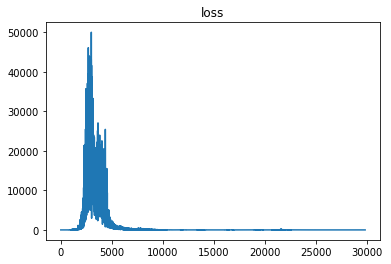

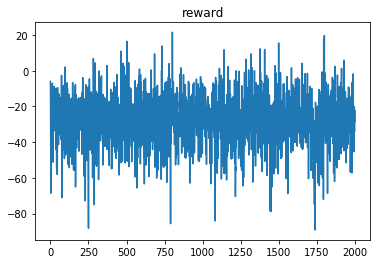

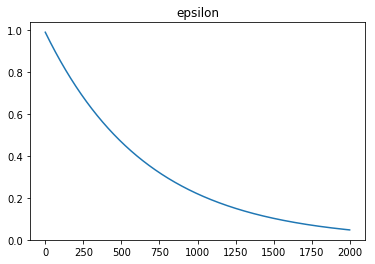

In [56]:
env = make_env()

n_episodes = 2000 # in the homework, please use more than 1000 episodes

n_agents = env.n
state_dim = env.observation_space[0].shape[0]
n_actions = env.action_space[0].n # we assume all homogeneous agents

# agent hyperparameters
hidden_dim=20
gamma=0.95
memory_size=1000
batch_size=20
epsilon_start = 0.99
epsilon_decay = 0.9999
epsilon_min= 0.01
update_target = 50
lamb = None

agent = Agent(n_agents, state_dim, n_actions, 
              hidden_dim=hidden_dim,
              gamma=gamma, 
              memory_size=memory_size,
              epsilon_start=epsilon_start,
              epsilon_decay=epsilon_decay,
              epsilon_min=epsilon_min,
              update_target=update_target,
              lamb=lamb
             )

# environmnt parameter
max_timestep = 15

# logging 
ep_reward_traj = []
loss_traj = []
epsilon_traj = []
for e in range(n_episodes):
    t = 0
    env.reset() # Reset everything to make clean start.
    terminated = False
    episode_reward = 0
    
    state = env.reset() # give you a list that contains each agent's observaion
    graph = generate_graph_with_obs(state)

    while True:             
        t += 1
        action, env_action = agent.get_action(graph)
        
        next_state, reward, terminated, _ = env.step(env_action)
        next_graph = generate_graph_with_obs(next_state)
        
        normlized_reward = [r  for r in reward]
        

        agent.save_samples(graph, action, normlized_reward, next_graph, terminated)
        
        trained, loss = agent.fit()
        
        if trained:
            loss_traj.append(loss)
            
        episode_reward += sum(normlized_reward)
        
        if all(terminated) or t >= max_timestep:
            ep_reward_traj.append(episode_reward)
            epsilon_traj.append(agent.epsilon)
            
            print("EP:{}, SUM_RWD:{:5.2f}, epsilon:{:5.2f}, loss:{:5.2f}".format(e, episode_reward, agent.epsilon, loss))
            
            break
            

env.close()

plt.plot(loss_traj)
plt.title('loss')
plt.show()

plt.plot(ep_reward_traj)
plt.title('reward')
plt.show()

plt.plot(epsilon_traj)
plt.title('epsilon')
plt.show()

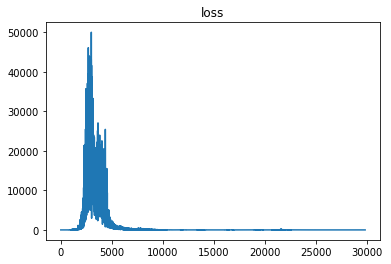

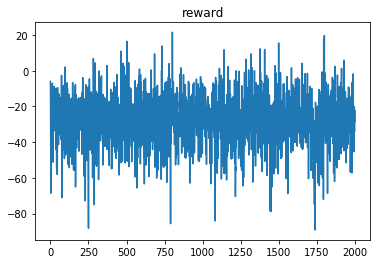

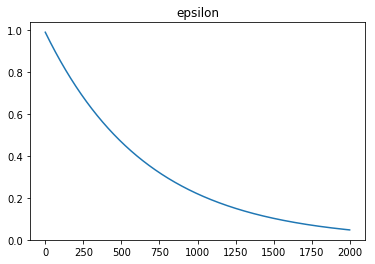

In [57]:
plt.plot(loss_traj)
plt.title('loss')
plt.show()

plt.plot(ep_reward_traj)

plt.title('reward')
plt.show()

plt.plot(epsilon_traj)
plt.title('epsilon')
plt.show()

# Experiment 2: With regularization

EP:0, SUM_RWD:-20.79, epsilon: 0.99, loss: 0.00
EP:1, SUM_RWD:-33.14, epsilon: 0.99, loss: 0.00
EP:2, SUM_RWD:-9.09, epsilon: 0.99, loss: 0.00
EP:3, SUM_RWD:-27.00, epsilon: 0.98, loss: 0.00
EP:4, SUM_RWD:-44.22, epsilon: 0.98, loss: 0.00
EP:5, SUM_RWD:-41.73, epsilon: 0.98, loss: 0.00
EP:6, SUM_RWD:-29.33, epsilon: 0.98, loss: 0.00
EP:7, SUM_RWD:-24.33, epsilon: 0.98, loss: 0.00
EP:8, SUM_RWD:-18.95, epsilon: 0.98, loss: 0.00
EP:9, SUM_RWD:-24.91, epsilon: 0.98, loss: 0.00
EP:10, SUM_RWD:-11.01, epsilon: 0.97, loss: 0.00
EP:11, SUM_RWD:-61.95, epsilon: 0.97, loss: 0.00
EP:12, SUM_RWD:-57.50, epsilon: 0.97, loss: 0.00
EP:13, SUM_RWD:-11.63, epsilon: 0.97, loss: 0.73
EP:14, SUM_RWD:-37.65, epsilon: 0.97, loss: 0.93
EP:15, SUM_RWD:-44.19, epsilon: 0.97, loss: 0.83
EP:16, SUM_RWD:-24.44, epsilon: 0.97, loss: 0.82
EP:17, SUM_RWD:-23.10, epsilon: 0.96, loss: 0.62
EP:18, SUM_RWD:-18.19, epsilon: 0.96, loss: 0.76
EP:19, SUM_RWD:-23.12, epsilon: 0.96, loss: 0.76
EP:20, SUM_RWD:-24.89, epsilon:

EP:167, SUM_RWD:-34.81, epsilon: 0.77, loss:285.33
EP:168, SUM_RWD:-41.59, epsilon: 0.77, loss:166.06
EP:169, SUM_RWD:-7.09, epsilon: 0.77, loss:529.75
EP:170, SUM_RWD:-20.33, epsilon: 0.77, loss:455.81
EP:171, SUM_RWD:-48.58, epsilon: 0.76, loss:652.52
EP:172, SUM_RWD:-29.44, epsilon: 0.76, loss:286.22
EP:173, SUM_RWD:-39.75, epsilon: 0.76, loss:784.40
EP:174, SUM_RWD:-31.39, epsilon: 0.76, loss:432.54
EP:175, SUM_RWD:-52.58, epsilon: 0.76, loss:296.00
EP:176, SUM_RWD:-34.36, epsilon: 0.76, loss:299.86
EP:177, SUM_RWD:-22.45, epsilon: 0.76, loss:717.11
EP:178, SUM_RWD:-53.86, epsilon: 0.76, loss:293.09
EP:179, SUM_RWD:-48.24, epsilon: 0.76, loss:585.18
EP:180, SUM_RWD:-24.21, epsilon: 0.75, loss:1748.07
EP:181, SUM_RWD:-35.55, epsilon: 0.75, loss:406.16
EP:182, SUM_RWD:-37.81, epsilon: 0.75, loss:329.57
EP:183, SUM_RWD:-6.26, epsilon: 0.75, loss:1741.03
EP:184, SUM_RWD:-21.99, epsilon: 0.75, loss:711.02
EP:185, SUM_RWD:-27.43, epsilon: 0.75, loss:658.88
EP:186, SUM_RWD:-29.72, epsilon

EP:330, SUM_RWD:-10.73, epsilon: 0.60, loss: 4.95
EP:331, SUM_RWD:-69.09, epsilon: 0.60, loss:13.60
EP:332, SUM_RWD:-36.49, epsilon: 0.60, loss:18.67
EP:333, SUM_RWD:-33.01, epsilon: 0.60, loss: 6.99
EP:334, SUM_RWD:-9.01, epsilon: 0.60, loss: 3.55
EP:335, SUM_RWD:-23.38, epsilon: 0.60, loss: 8.34
EP:336, SUM_RWD:-3.37, epsilon: 0.60, loss: 9.18
EP:337, SUM_RWD:-34.56, epsilon: 0.60, loss: 8.60
EP:338, SUM_RWD:-43.48, epsilon: 0.60, loss:11.67
EP:339, SUM_RWD:-54.89, epsilon: 0.59, loss:12.39
EP:340, SUM_RWD:-3.33, epsilon: 0.59, loss: 5.06
EP:341, SUM_RWD:-36.23, epsilon: 0.59, loss: 5.60
EP:342, SUM_RWD:-43.84, epsilon: 0.59, loss:18.99
EP:343, SUM_RWD:-26.80, epsilon: 0.59, loss: 4.04
EP:344, SUM_RWD:-38.01, epsilon: 0.59, loss: 9.29
EP:345, SUM_RWD:-47.75, epsilon: 0.59, loss:11.44
EP:346, SUM_RWD:-34.66, epsilon: 0.59, loss: 7.85
EP:347, SUM_RWD:-51.54, epsilon: 0.59, loss:20.17
EP:348, SUM_RWD:-44.20, epsilon: 0.59, loss:19.50
EP:349, SUM_RWD:-10.95, epsilon: 0.59, loss:12.10
EP:

EP:496, SUM_RWD:-66.61, epsilon: 0.47, loss: 0.88
EP:497, SUM_RWD:-77.74, epsilon: 0.47, loss: 0.81
EP:498, SUM_RWD:-24.06, epsilon: 0.47, loss: 1.08
EP:499, SUM_RWD:-33.90, epsilon: 0.47, loss: 0.79
EP:500, SUM_RWD:-35.90, epsilon: 0.47, loss: 2.17
EP:501, SUM_RWD:-44.48, epsilon: 0.47, loss: 1.35
EP:502, SUM_RWD:-48.72, epsilon: 0.47, loss: 0.94
EP:503, SUM_RWD:-35.88, epsilon: 0.46, loss: 0.84
EP:504, SUM_RWD:-44.96, epsilon: 0.46, loss: 0.57
EP:505, SUM_RWD:-49.10, epsilon: 0.46, loss: 2.51
EP:506, SUM_RWD:-16.98, epsilon: 0.46, loss: 0.79
EP:507, SUM_RWD:-42.10, epsilon: 0.46, loss: 1.25
EP:508, SUM_RWD:-60.02, epsilon: 0.46, loss: 1.36
EP:509, SUM_RWD:-15.45, epsilon: 0.46, loss:  nan
EP:510, SUM_RWD:-27.57, epsilon: 0.46, loss:  nan
EP:511, SUM_RWD:-34.75, epsilon: 0.46, loss:  nan
EP:512, SUM_RWD:-33.58, epsilon: 0.46, loss:  nan
EP:513, SUM_RWD:-1.71, epsilon: 0.46, loss:  nan
EP:514, SUM_RWD:-36.21, epsilon: 0.46, loss:  nan
EP:515, SUM_RWD:-30.52, epsilon: 0.46, loss:  nan
E

EP:662, SUM_RWD:-25.62, epsilon: 0.37, loss:  nan
EP:663, SUM_RWD:-27.20, epsilon: 0.37, loss:  nan
EP:664, SUM_RWD:-15.99, epsilon: 0.37, loss:  nan
EP:665, SUM_RWD:-23.33, epsilon: 0.36, loss:  nan
EP:666, SUM_RWD:-47.28, epsilon: 0.36, loss:  nan
EP:667, SUM_RWD:-33.00, epsilon: 0.36, loss:  nan
EP:668, SUM_RWD:-0.93, epsilon: 0.36, loss:  nan
EP:669, SUM_RWD:-37.63, epsilon: 0.36, loss:  nan
EP:670, SUM_RWD:-46.15, epsilon: 0.36, loss:  nan
EP:671, SUM_RWD:-26.97, epsilon: 0.36, loss:  nan
EP:672, SUM_RWD:-20.45, epsilon: 0.36, loss:  nan
EP:673, SUM_RWD:-36.15, epsilon: 0.36, loss:  nan
EP:674, SUM_RWD:-34.63, epsilon: 0.36, loss:  nan
EP:675, SUM_RWD:-29.30, epsilon: 0.36, loss:  nan
EP:676, SUM_RWD:-37.59, epsilon: 0.36, loss:  nan
EP:677, SUM_RWD:-23.08, epsilon: 0.36, loss:  nan
EP:678, SUM_RWD:-23.19, epsilon: 0.36, loss:  nan
EP:679, SUM_RWD:-22.96, epsilon: 0.36, loss:  nan
EP:680, SUM_RWD:-28.37, epsilon: 0.36, loss:  nan
EP:681, SUM_RWD:-48.40, epsilon: 0.36, loss:  nan
E

EP:828, SUM_RWD:-47.62, epsilon: 0.29, loss:  nan
EP:829, SUM_RWD:-32.75, epsilon: 0.29, loss:  nan
EP:830, SUM_RWD:-28.88, epsilon: 0.28, loss:  nan
EP:831, SUM_RWD:-31.53, epsilon: 0.28, loss:  nan
EP:832, SUM_RWD:-38.29, epsilon: 0.28, loss:  nan
EP:833, SUM_RWD:-58.92, epsilon: 0.28, loss:  nan
EP:834, SUM_RWD:-22.49, epsilon: 0.28, loss:  nan
EP:835, SUM_RWD:-23.22, epsilon: 0.28, loss:  nan
EP:836, SUM_RWD: 7.30, epsilon: 0.28, loss:  nan
EP:837, SUM_RWD:-35.58, epsilon: 0.28, loss:  nan
EP:838, SUM_RWD:-32.81, epsilon: 0.28, loss:  nan
EP:839, SUM_RWD:-1.30, epsilon: 0.28, loss:  nan
EP:840, SUM_RWD:-12.41, epsilon: 0.28, loss:  nan
EP:841, SUM_RWD:-25.01, epsilon: 0.28, loss:  nan
EP:842, SUM_RWD:-32.69, epsilon: 0.28, loss:  nan
EP:843, SUM_RWD:-29.25, epsilon: 0.28, loss:  nan
EP:844, SUM_RWD:-28.21, epsilon: 0.28, loss:  nan
EP:845, SUM_RWD:-25.93, epsilon: 0.28, loss:  nan
EP:846, SUM_RWD:-24.45, epsilon: 0.28, loss:  nan
EP:847, SUM_RWD:-21.50, epsilon: 0.28, loss:  nan
EP

EP:993, SUM_RWD:-30.51, epsilon: 0.22, loss:  nan
EP:994, SUM_RWD:-30.43, epsilon: 0.22, loss:  nan
EP:995, SUM_RWD:-41.07, epsilon: 0.22, loss:  nan
EP:996, SUM_RWD:-8.29, epsilon: 0.22, loss:  nan
EP:997, SUM_RWD:-12.58, epsilon: 0.22, loss:  nan
EP:998, SUM_RWD:-13.13, epsilon: 0.22, loss:  nan
EP:999, SUM_RWD:-38.00, epsilon: 0.22, loss:  nan
EP:1000, SUM_RWD:-21.28, epsilon: 0.22, loss:  nan
EP:1001, SUM_RWD:-55.07, epsilon: 0.22, loss:  nan
EP:1002, SUM_RWD:-27.30, epsilon: 0.22, loss:  nan
EP:1003, SUM_RWD:-16.71, epsilon: 0.22, loss:  nan
EP:1004, SUM_RWD:-23.45, epsilon: 0.22, loss:  nan
EP:1005, SUM_RWD:-26.35, epsilon: 0.22, loss:  nan
EP:1006, SUM_RWD:-18.99, epsilon: 0.22, loss:  nan
EP:1007, SUM_RWD:-22.17, epsilon: 0.22, loss:  nan
EP:1008, SUM_RWD:-32.41, epsilon: 0.22, loss:  nan
EP:1009, SUM_RWD:-21.24, epsilon: 0.22, loss:  nan
EP:1010, SUM_RWD:-42.83, epsilon: 0.22, loss:  nan
EP:1011, SUM_RWD:-30.27, epsilon: 0.22, loss:  nan
EP:1012, SUM_RWD:-16.30, epsilon: 0.22,

EP:1155, SUM_RWD:-25.84, epsilon: 0.17, loss:  nan
EP:1156, SUM_RWD:-42.51, epsilon: 0.17, loss:  nan
EP:1157, SUM_RWD:-19.52, epsilon: 0.17, loss:  nan
EP:1158, SUM_RWD:-28.78, epsilon: 0.17, loss:  nan
EP:1159, SUM_RWD:-15.40, epsilon: 0.17, loss:  nan
EP:1160, SUM_RWD:-37.69, epsilon: 0.17, loss:  nan
EP:1161, SUM_RWD:-40.45, epsilon: 0.17, loss:  nan
EP:1162, SUM_RWD:-19.25, epsilon: 0.17, loss:  nan
EP:1163, SUM_RWD:-26.81, epsilon: 0.17, loss:  nan
EP:1164, SUM_RWD:-26.30, epsilon: 0.17, loss:  nan
EP:1165, SUM_RWD:-23.74, epsilon: 0.17, loss:  nan
EP:1166, SUM_RWD:-11.37, epsilon: 0.17, loss:  nan
EP:1167, SUM_RWD:-41.47, epsilon: 0.17, loss:  nan
EP:1168, SUM_RWD:-23.97, epsilon: 0.17, loss:  nan
EP:1169, SUM_RWD:-19.26, epsilon: 0.17, loss:  nan
EP:1170, SUM_RWD:-25.49, epsilon: 0.17, loss:  nan
EP:1171, SUM_RWD:-5.45, epsilon: 0.17, loss:  nan
EP:1172, SUM_RWD:-24.24, epsilon: 0.17, loss:  nan
EP:1173, SUM_RWD:-30.30, epsilon: 0.17, loss:  nan
EP:1174, SUM_RWD:-37.52, epsilon

EP:1317, SUM_RWD: 3.31, epsilon: 0.14, loss:  nan
EP:1318, SUM_RWD:-31.40, epsilon: 0.14, loss:  nan
EP:1319, SUM_RWD:-49.23, epsilon: 0.14, loss:  nan
EP:1320, SUM_RWD:-29.96, epsilon: 0.14, loss:  nan
EP:1321, SUM_RWD:-37.41, epsilon: 0.14, loss:  nan
EP:1322, SUM_RWD:-21.25, epsilon: 0.14, loss:  nan
EP:1323, SUM_RWD:-28.80, epsilon: 0.14, loss:  nan
EP:1324, SUM_RWD:-14.97, epsilon: 0.14, loss:  nan
EP:1325, SUM_RWD:-41.92, epsilon: 0.14, loss:  nan
EP:1326, SUM_RWD:-26.22, epsilon: 0.14, loss:  nan
EP:1327, SUM_RWD:-25.09, epsilon: 0.14, loss:  nan
EP:1328, SUM_RWD:-31.42, epsilon: 0.13, loss:  nan
EP:1329, SUM_RWD:-20.73, epsilon: 0.13, loss:  nan
EP:1330, SUM_RWD:-34.64, epsilon: 0.13, loss:  nan
EP:1331, SUM_RWD:-32.88, epsilon: 0.13, loss:  nan
EP:1332, SUM_RWD:-14.70, epsilon: 0.13, loss:  nan
EP:1333, SUM_RWD:-35.61, epsilon: 0.13, loss:  nan
EP:1334, SUM_RWD:-20.11, epsilon: 0.13, loss:  nan
EP:1335, SUM_RWD:-49.00, epsilon: 0.13, loss:  nan
EP:1336, SUM_RWD:-11.31, epsilon

EP:1478, SUM_RWD:-13.19, epsilon: 0.11, loss:  nan
EP:1479, SUM_RWD:-32.53, epsilon: 0.11, loss:  nan
EP:1480, SUM_RWD:-29.82, epsilon: 0.11, loss:  nan
EP:1481, SUM_RWD:-21.98, epsilon: 0.11, loss:  nan
EP:1482, SUM_RWD:-35.78, epsilon: 0.11, loss:  nan
EP:1483, SUM_RWD:-24.77, epsilon: 0.11, loss:  nan
EP:1484, SUM_RWD:-29.01, epsilon: 0.11, loss:  nan
EP:1485, SUM_RWD:-31.61, epsilon: 0.11, loss:  nan
EP:1486, SUM_RWD:-31.14, epsilon: 0.11, loss:  nan
EP:1487, SUM_RWD:-30.27, epsilon: 0.11, loss:  nan
EP:1488, SUM_RWD:-8.49, epsilon: 0.11, loss:  nan
EP:1489, SUM_RWD:-9.89, epsilon: 0.11, loss:  nan
EP:1490, SUM_RWD: 5.18, epsilon: 0.11, loss:  nan
EP:1491, SUM_RWD:-31.29, epsilon: 0.11, loss:  nan
EP:1492, SUM_RWD:-9.37, epsilon: 0.11, loss:  nan
EP:1493, SUM_RWD:-34.96, epsilon: 0.11, loss:  nan
EP:1494, SUM_RWD:-20.88, epsilon: 0.11, loss:  nan
EP:1495, SUM_RWD:-20.80, epsilon: 0.10, loss:  nan
EP:1496, SUM_RWD:-19.78, epsilon: 0.10, loss:  nan
EP:1497, SUM_RWD:-16.14, epsilon: 0

EP:1640, SUM_RWD:-38.13, epsilon: 0.08, loss:  nan
EP:1641, SUM_RWD:-26.00, epsilon: 0.08, loss:  nan
EP:1642, SUM_RWD:-17.64, epsilon: 0.08, loss:  nan
EP:1643, SUM_RWD:-21.85, epsilon: 0.08, loss:  nan
EP:1644, SUM_RWD:-30.43, epsilon: 0.08, loss:  nan
EP:1645, SUM_RWD:-44.31, epsilon: 0.08, loss:  nan
EP:1646, SUM_RWD:-41.16, epsilon: 0.08, loss:  nan
EP:1647, SUM_RWD:-1.72, epsilon: 0.08, loss:  nan
EP:1648, SUM_RWD:-32.55, epsilon: 0.08, loss:  nan
EP:1649, SUM_RWD:-26.36, epsilon: 0.08, loss:  nan
EP:1650, SUM_RWD:-36.70, epsilon: 0.08, loss:  nan
EP:1651, SUM_RWD:-37.19, epsilon: 0.08, loss:  nan
EP:1652, SUM_RWD:-33.14, epsilon: 0.08, loss:  nan
EP:1653, SUM_RWD:-45.59, epsilon: 0.08, loss:  nan
EP:1654, SUM_RWD:-31.91, epsilon: 0.08, loss:  nan
EP:1655, SUM_RWD:-37.72, epsilon: 0.08, loss:  nan
EP:1656, SUM_RWD:-10.82, epsilon: 0.08, loss:  nan
EP:1657, SUM_RWD:-7.93, epsilon: 0.08, loss:  nan
EP:1658, SUM_RWD:-32.80, epsilon: 0.08, loss:  nan
EP:1659, SUM_RWD:-4.36, epsilon: 

EP:1803, SUM_RWD:-22.67, epsilon: 0.07, loss:  nan
EP:1804, SUM_RWD:-33.33, epsilon: 0.07, loss:  nan
EP:1805, SUM_RWD:-32.25, epsilon: 0.07, loss:  nan
EP:1806, SUM_RWD:-30.61, epsilon: 0.07, loss:  nan
EP:1807, SUM_RWD:-23.46, epsilon: 0.07, loss:  nan
EP:1808, SUM_RWD:-30.67, epsilon: 0.07, loss:  nan
EP:1809, SUM_RWD: 3.37, epsilon: 0.07, loss:  nan
EP:1810, SUM_RWD:-32.72, epsilon: 0.07, loss:  nan
EP:1811, SUM_RWD:-62.05, epsilon: 0.07, loss:  nan
EP:1812, SUM_RWD:-4.93, epsilon: 0.07, loss:  nan
EP:1813, SUM_RWD:-9.07, epsilon: 0.07, loss:  nan
EP:1814, SUM_RWD:-21.78, epsilon: 0.07, loss:  nan
EP:1815, SUM_RWD:-14.00, epsilon: 0.06, loss:  nan
EP:1816, SUM_RWD:-30.55, epsilon: 0.06, loss:  nan
EP:1817, SUM_RWD:-33.35, epsilon: 0.06, loss:  nan
EP:1818, SUM_RWD:-30.05, epsilon: 0.06, loss:  nan
EP:1819, SUM_RWD:-36.68, epsilon: 0.06, loss:  nan
EP:1820, SUM_RWD:-18.62, epsilon: 0.06, loss:  nan
EP:1821, SUM_RWD:-42.34, epsilon: 0.06, loss:  nan
EP:1822, SUM_RWD:-7.00, epsilon: 0

EP:1966, SUM_RWD:-29.47, epsilon: 0.05, loss:  nan
EP:1967, SUM_RWD:-9.80, epsilon: 0.05, loss:  nan
EP:1968, SUM_RWD:-13.19, epsilon: 0.05, loss:  nan
EP:1969, SUM_RWD:-18.67, epsilon: 0.05, loss:  nan
EP:1970, SUM_RWD:-25.00, epsilon: 0.05, loss:  nan
EP:1971, SUM_RWD:-49.54, epsilon: 0.05, loss:  nan
EP:1972, SUM_RWD:-12.00, epsilon: 0.05, loss:  nan
EP:1973, SUM_RWD:-19.57, epsilon: 0.05, loss:  nan
EP:1974, SUM_RWD:-20.73, epsilon: 0.05, loss:  nan
EP:1975, SUM_RWD:-32.93, epsilon: 0.05, loss:  nan
EP:1976, SUM_RWD:-25.92, epsilon: 0.05, loss:  nan
EP:1977, SUM_RWD:-36.75, epsilon: 0.05, loss:  nan
EP:1978, SUM_RWD:-36.28, epsilon: 0.05, loss:  nan
EP:1979, SUM_RWD:-20.84, epsilon: 0.05, loss:  nan
EP:1980, SUM_RWD:-24.53, epsilon: 0.05, loss:  nan
EP:1981, SUM_RWD:-37.45, epsilon: 0.05, loss:  nan
EP:1982, SUM_RWD:-26.13, epsilon: 0.05, loss:  nan
EP:1983, SUM_RWD:-14.87, epsilon: 0.05, loss:  nan
EP:1984, SUM_RWD:-36.38, epsilon: 0.05, loss:  nan
EP:1985, SUM_RWD:-5.09, epsilon:

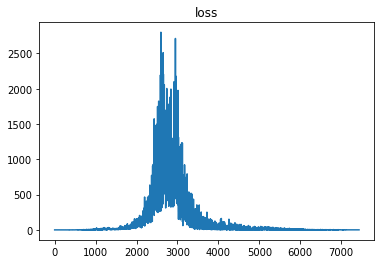

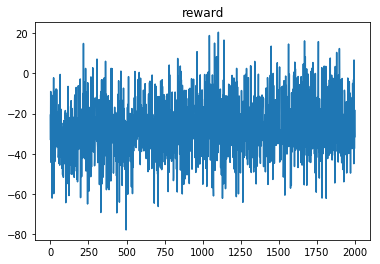

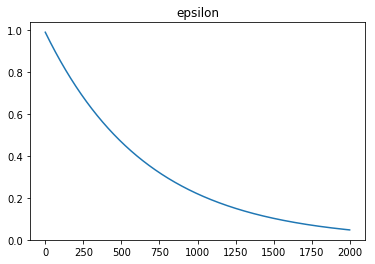

In [47]:
env = make_env()

n_episodes = 2000 # in the homework, please use more than 1000 episodes

n_agents = env.n
state_dim = env.observation_space[0].shape[0]
n_actions = env.action_space[0].n # we assume all homogeneous agents

# agent hyperparameters
hidden_dim=20
gamma=0.9
memory_size=1000
batch_size=20
epsilon_start = 0.99
epsilon_decay = 0.9999
epsilon_min= 0.01
update_target = 50
lamb = 0.5

agent = Agent(n_agents, state_dim, n_actions, 
              hidden_dim=hidden_dim,
              gamma=gamma, 
              memory_size=memory_size,
              epsilon_start=epsilon_start,
              epsilon_decay=epsilon_decay,
              epsilon_min=epsilon_min,
              update_target=update_target,
              lamb=lamb
             )

# environmnt parameter
max_timestep = 15

# logging 
ep_reward_traj = []
loss_traj = []
epsilon_traj = []
for e in range(n_episodes):
    t = 0
    env.reset() # Reset everything to make clean start.
    terminated = False
    episode_reward = 0
    
    state = env.reset() # give you a list that contains each agent's observaion
    graph = generate_graph_with_obs(state)

    while True:             
        t += 1
        action, env_action = agent.get_action(graph)
        
        next_state, reward, terminated, _ = env.step(env_action)
        next_graph = generate_graph_with_obs(next_state)
        
        normlized_reward = [r  for r in reward]
        

        agent.save_samples(graph, action, normlized_reward, next_graph, terminated)
        
        trained, loss = agent.fit()
        
        if trained:
            loss_traj.append(loss)
            
        episode_reward += sum(normlized_reward)
        
        if all(terminated) or t >= max_timestep:
            ep_reward_traj.append(episode_reward)
            epsilon_traj.append(agent.epsilon)
            
            print("EP:{}, SUM_RWD:{:5.2f}, epsilon:{:5.2f}, loss:{:5.2f}".format(e, episode_reward, agent.epsilon, loss))
            
            break
            

env.close()

plt.plot(loss_traj)
plt.title('loss')
plt.show()

plt.plot(ep_reward_traj)
plt.title('reward')
plt.show()

plt.plot(epsilon_traj)
plt.title('epsilon')
plt.show()

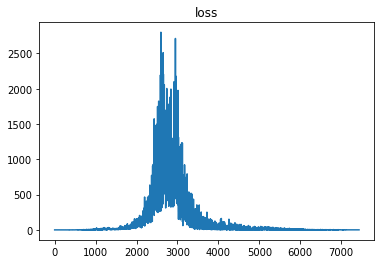

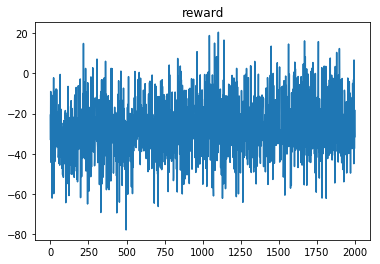

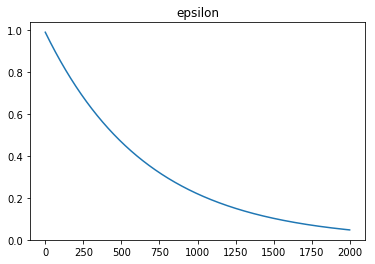

In [48]:
plt.plot(loss_traj)
plt.title('loss')
plt.show()

plt.plot(ep_reward_traj)

plt.title('reward')
plt.show()

plt.plot(epsilon_traj)
plt.title('epsilon')
plt.show()

## Testing Trained agents

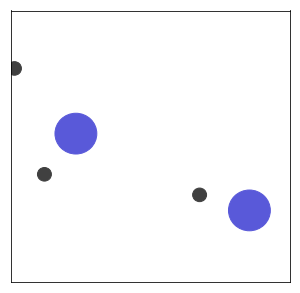

In [58]:
n_episodes = 1 
max_timestep = 100
agent.epsilon = 0

for e in range(n_episodes):
    t = 0
    env.reset() # Reset everything to make clean start.
    terminated = False    
    state = env.reset() # give you a list that contains each agent's observaion
    graph = generate_graph_with_obs(state)

    while True:             
        vis_state(env)
        t += 1
        action, env_action = agent.get_action(graph)
        
        next_state, reward, terminated, _ = env.step(env_action)
        next_graph = generate_graph_with_obs(next_state)
                
        if all(terminated) or t >= max_timestep:
            
            break